In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Reproducibility
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

# Dataset Generation

In [4]:
def generate_make_moons(n_samples=500, noise=0.2, imbalance_ratio=0.5, random_state=1337):
    rng = np.random.RandomState(random_state)

    # Compute number of samples per class
    n_samples_class_0 = int(n_samples * imbalance_ratio)
    n_samples_class_1 = n_samples - n_samples_class_0

    # Generate moon-shaped data for each class
    angle0 = np.linspace(0, np.pi, n_samples_class_0)
    x_class_0 = np.column_stack([np.cos(angle0), np.sin(angle0)])

    angle1 = np.linspace(0, np.pi, n_samples_class_1)
    x_class_1 = np.column_stack([1 - np.cos(angle1), 0.5 - np.sin(angle1)])

    # Combine and add Gaussian noise
    X = np.vstack([x_class_0, x_class_1])
    y = np.hstack([np.zeros(n_samples_class_0), np.ones(n_samples_class_1)])
    X += rng.normal(scale=noise, size=X.shape)

    return X, y

In [5]:
# Base dataset
X_base, y_base = generate_make_moons(n_samples=1000, noise=0.2, imbalance_ratio=0.5, random_state=SEED)

In [6]:
# Split into train + test (each 500 samples)
X_train, X_test, y_train, y_test = train_test_split(
    X_base, y_base, test_size=0.5, random_state=SEED, stratify=y_base
)

In [7]:
# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

In [8]:
# Robustness test sets with different noise levels
X_test_low, y_test_low = generate_make_moons(500, noise=0.1, imbalance_ratio=0.5, random_state=SEED)
X_test_high, y_test_high = generate_make_moons(500, noise=0.3, imbalance_ratio=0.5, random_state=SEED)

In [9]:
# Standardize X using train stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_test_low = scaler.transform(X_test_low)
X_test_high = scaler.transform(X_test_high)

# Model Training

In [10]:
# Convert numpy arrays to pytorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [11]:
# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)

**MLP with No Regularization, and with Early Stopping**

In [12]:
# Define baseline MLP model
class MLP(nn.Module):
    def __init__(self, hidden_layer_dim=16):
        super().__init__()
        self.hidden = nn.Linear(2, hidden_layer_dim)
        self.out = nn.Linear(hidden_layer_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        logits = self.out(x)
        return logits

In [13]:
def train_mlp_no_reg(train_loader, val_loader):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    patience = 50
    best_val_auc = 0
    patience_counter = 0
    best_state = None

    for epoch in range(10000):
        # Training
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        y_val_pred = []
        with torch.no_grad():
            for xb, _ in val_loader:
                logits = model(xb)
                probs = torch.sigmoid(logits)
                y_val_pred.append(probs)
        y_val_pred = torch.cat(y_val_pred).numpy()
        val_auroc = roc_auc_score(y_val_t.numpy(), y_val_pred)

        if epoch % 50 == 0:
            print(f"Epoch {epoch:d} | Train Loss={train_loss:.4f} | Val AUROC={val_auroc:.4f}")

        # Early Stopping
        if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Restore best model
    model.load_state_dict(best_state)
    return model, best_val_auc

In [14]:
# Train the model with early stopping
model_mlp, best_val_auc = train_mlp_no_reg(train_loader, val_loader)

Epoch 0 | Train Loss=8.7898 | Val AUROC=0.7420
Epoch 50 | Train Loss=4.1079 | Val AUROC=0.9256
Epoch 100 | Train Loss=3.8975 | Val AUROC=0.9344
Epoch 150 | Train Loss=3.2346 | Val AUROC=0.9532
Epoch 200 | Train Loss=2.7491 | Val AUROC=0.9692
Epoch 250 | Train Loss=2.1195 | Val AUROC=0.9796
Epoch 300 | Train Loss=1.7730 | Val AUROC=0.9864
Epoch 350 | Train Loss=1.4852 | Val AUROC=0.9896
Epoch 400 | Train Loss=1.3486 | Val AUROC=0.9932
Epoch 450 | Train Loss=1.1863 | Val AUROC=0.9936
Epoch 500 | Train Loss=1.1595 | Val AUROC=0.9948
Early stopping at epoch 535


In [16]:
# Validation AUROC
print(f"Val AUROC: {best_val_auc:.4f}")

Val AUROC: 0.9952


**MLP with L1 Regularization**

In [17]:
def train_with_l1(lambda_l1, train_loader, val_loader):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    patience = 50
    best_val_auc = 0
    patience_counter = 0
    best_state = None

    for epoch in range(10000):
        # Training
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            # Add L1 regularization term
            l1_penalty = 0.0
            for param in model.parameters():
                l1_penalty += torch.sum(torch.abs(param))
            loss = loss + lambda_l1 * l1_penalty

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        y_val_pred = []
        with torch.no_grad():
            for xb, _ in val_loader:
                logits = model(xb)
                probs = torch.sigmoid(logits)
                y_val_pred.append(probs)
        y_val_pred = torch.cat(y_val_pred).numpy()
        val_auroc = roc_auc_score(y_val_t.numpy(), y_val_pred)

        if epoch % 50 == 0:
            print(f"Epoch {epoch:d} | Train Loss={train_loss:.4f} | Val AUROC={val_auroc:.4f}")

        # Early Stopping
        if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Restore best model
    model.load_state_dict(best_state)
    return model, best_val_auc

In [18]:
# Function to compute layerwise sparsity
def compute_sparsity(model, threshold=1e-3):
    sparsities = {}
    with torch.no_grad():
        for name, param in model.named_parameters():
            if "weight" in name:
                zero_count = torch.sum(torch.abs(param) < threshold).item() 
                total = param.numel()
                sparsities[name] = 100 * zero_count / total
    return sparsities

In [28]:
# List of lambda values given
lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]

In [20]:
results = []

for lam in lambdas:
    print(f"Taking Lambda={lam:.1e}")
    model, auc = train_with_l1(lam, train_loader, val_loader)
    sparsity = compute_sparsity(model)
    results.append({
        "Lambda": lam,
        "Val_AUROC": auc,
        "Hidden_Sparsity(%)": sparsity['hidden.weight'],
        "Out_Sparsity(%)": sparsity['out.weight']
    })
    print(f"λ={lam:.1e} | Val AUROC={auc:.4f} | Hidden layer Sparsity={sparsity['hidden.weight']:.2f}% | Output layer Sparsity={sparsity['out.weight']:.2f}%\n")

Taking Lambda=1.0e-06
Epoch 0 | Train Loss=9.6492 | Val AUROC=0.3356
Epoch 50 | Train Loss=4.0200 | Val AUROC=0.9296
Epoch 100 | Train Loss=3.7763 | Val AUROC=0.9388
Epoch 150 | Train Loss=3.2830 | Val AUROC=0.9524
Epoch 200 | Train Loss=2.8786 | Val AUROC=0.9704
Epoch 250 | Train Loss=2.2032 | Val AUROC=0.9824
Epoch 300 | Train Loss=1.8538 | Val AUROC=0.9904
Epoch 350 | Train Loss=1.4742 | Val AUROC=0.9940
Epoch 400 | Train Loss=1.3218 | Val AUROC=0.9952
Epoch 450 | Train Loss=1.2521 | Val AUROC=0.9956
Epoch 500 | Train Loss=1.1977 | Val AUROC=0.9960
Early stopping at epoch 545
λ=1.0e-06 | Val AUROC=0.9964 | Hidden layer Sparsity=3.12% | Output layer Sparsity=6.25%

Taking Lambda=3.0e-06
Epoch 0 | Train Loss=8.6836 | Val AUROC=0.9060
Epoch 50 | Train Loss=3.6921 | Val AUROC=0.9444
Epoch 100 | Train Loss=2.9081 | Val AUROC=0.9644
Epoch 150 | Train Loss=2.2812 | Val AUROC=0.9788
Epoch 200 | Train Loss=1.7965 | Val AUROC=0.9872
Epoch 250 | Train Loss=1.4974 | Val AUROC=0.9916
Epoch 300 |

In [21]:
# Find the best lambda based on Validation AUROC
best_result = max(results, key=lambda x: x["Val_AUROC"])
best_lambda = best_result["Lambda"]
print(f"Best lambda for L1 regularization: {best_lambda:.1e}")

Best lambda for L1 regularization: 1.0e-06


In [22]:
# Retrain MLP with best lambda
model_l1, best_l1_auc = train_with_l1(best_lambda, train_loader, val_loader)
print(f"Retrained L1 MLP with λ={best_lambda:.1e}, Validation AUROC={best_l1_auc:.4f}")

# Compute sparsity for the final model
final_sparsity = compute_sparsity(model_l1)
print(f"Final Hidden Sparsity: {final_sparsity['hidden.weight']:.2f}% | Out Sparsity: {final_sparsity['out.weight']:.2f}%")


Epoch 0 | Train Loss=8.6975 | Val AUROC=0.7916
Epoch 50 | Train Loss=3.9814 | Val AUROC=0.9344
Epoch 100 | Train Loss=3.3859 | Val AUROC=0.9484
Epoch 150 | Train Loss=2.7218 | Val AUROC=0.9700
Epoch 200 | Train Loss=2.1092 | Val AUROC=0.9808
Epoch 250 | Train Loss=1.6961 | Val AUROC=0.9880
Epoch 300 | Train Loss=1.4364 | Val AUROC=0.9924
Epoch 350 | Train Loss=1.2966 | Val AUROC=0.9944
Epoch 400 | Train Loss=1.1601 | Val AUROC=0.9956
Early stopping at epoch 430
Retrained L1 MLP with λ=1.0e-06, Validation AUROC=0.9956
Final Hidden Sparsity: 0.00% | Out Sparsity: 0.00%


**MLP with L2 regularization**

In [29]:
def train_with_l2(lambda_l2, train_loader, val_loader):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    patience = 50
    best_val_auc = 0
    patience_counter = 0
    best_state = None

    for epoch in range(10000):
        # Training
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            # L2 regularization
            l2_penalty = 0.0
            for param in model.parameters():
                l2_penalty += torch.sum(param ** 2)
            loss = loss + lambda_l2 * l2_penalty

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        y_val_pred = []
        with torch.no_grad():
            for xb, _ in val_loader:
                probs = torch.sigmoid(model(xb))
                y_val_pred.append(probs)
        y_val_pred = torch.cat(y_val_pred).cpu().numpy()
        val_auc = roc_auc_score(y_val_t.cpu().numpy(), y_val_pred)

        # Print every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch:d} | Train Loss={train_loss:.4f} | Val AUROC={val_auc:.4f}")

        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best model
    model.load_state_dict(best_state)
    return model, best_val_auc


In [24]:
# Lambdas for L2 penalty
l2_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]

In [25]:
results = []

for lam in l2_lambdas:
    print(f"Taking lambda={lam:.1e}")
    model, auc = train_with_l2(lam, train_loader, val_loader)

    # Compute L2 norm of weights (for reporting)
    with torch.no_grad():
        weight_norm = sum(
        torch.norm(p).item()**2
        for name, p in model.named_parameters()
        if "weight" in name
    )

    results.append({
        "Lambda": lam,
        "Val_AUROC": auc
    })
    print(f"Lambda={lam:.1e} | Val AUROC={auc:.4f}\n")

Taking lambda=1.0e-06
Epoch 0 | Train Loss=8.5121 | Val AUROC=0.8744
Epoch 50 | Train Loss=3.7829 | Val AUROC=0.9376
Epoch 100 | Train Loss=3.1797 | Val AUROC=0.9580
Epoch 150 | Train Loss=2.4536 | Val AUROC=0.9752
Epoch 200 | Train Loss=2.0033 | Val AUROC=0.9836
Epoch 250 | Train Loss=1.5820 | Val AUROC=0.9892
Epoch 300 | Train Loss=1.3689 | Val AUROC=0.9936
Epoch 350 | Train Loss=1.2599 | Val AUROC=0.9944
Epoch 400 | Train Loss=1.1679 | Val AUROC=0.9956
Early stopping at epoch 448
Lambda=1.0e-06 | Val AUROC=0.9956

Taking lambda=3.0e-06
Epoch 0 | Train Loss=8.3003 | Val AUROC=0.7464
Epoch 50 | Train Loss=3.8048 | Val AUROC=0.9408
Epoch 100 | Train Loss=3.2102 | Val AUROC=0.9600
Epoch 150 | Train Loss=2.3866 | Val AUROC=0.9780
Epoch 200 | Train Loss=1.8535 | Val AUROC=0.9852
Epoch 250 | Train Loss=1.5272 | Val AUROC=0.9908
Epoch 300 | Train Loss=1.3081 | Val AUROC=0.9932
Epoch 350 | Train Loss=1.1898 | Val AUROC=0.9948
Early stopping at epoch 383
Lambda=3.0e-06 | Val AUROC=0.9948

Tak

In [26]:
# Find the best L2 lambda based on Validation AUROC
best_l2_result = max(results, key=lambda x: x["Val_AUROC"])
best_lambda_l2 = best_l2_result["Lambda"]

print(f"Best lambda for L2 regularization: {best_lambda_l2:.1e}")

Best lambda for L2 regularization: 1.0e-06


In [27]:
# Retrain MLP with best L2 regularization parameter
model_l2, final_val_auc = train_with_l2(best_lambda_l2, train_loader, val_loader)

print(f"Best lambda = {best_lambda_l2:.1e}")
print(f"Validation AUROC = {final_val_auc:.4f}")

Epoch 0 | Train Loss=9.1310 | Val AUROC=0.6540
Epoch 50 | Train Loss=3.9418 | Val AUROC=0.9344
Epoch 100 | Train Loss=3.4507 | Val AUROC=0.9456
Epoch 150 | Train Loss=3.0116 | Val AUROC=0.9612
Epoch 200 | Train Loss=2.3509 | Val AUROC=0.9744
Epoch 250 | Train Loss=1.8705 | Val AUROC=0.9816
Epoch 300 | Train Loss=1.4981 | Val AUROC=0.9904
Epoch 350 | Train Loss=1.2938 | Val AUROC=0.9928
Epoch 400 | Train Loss=1.1730 | Val AUROC=0.9948
Epoch 450 | Train Loss=1.0621 | Val AUROC=0.9956
Epoch 500 | Train Loss=1.0240 | Val AUROC=0.9968
Epoch 550 | Train Loss=0.9631 | Val AUROC=0.9972
Early stopping at epoch 575
Best lambda = 1.0e-06
Validation AUROC = 0.9972


**Logistic Regression with Polynomial Features**

In [30]:
# Polynomial features of degree 2 (x1^2, x2^2, x1*x2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)
X_test_poly = poly.transform(X_test)
X_test_low_poly = poly.transform(X_test_low)
X_test_high_poly = poly.transform(X_test_high)

In [31]:
# Train logistic regression model
logreg = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg.fit(X_train_poly, y_train)

LogisticRegression(max_iter=5000)

In [32]:
# Predictions on validation set
y_val_pred = logreg.predict(X_val_poly)
y_val_prob = logreg.predict_proba(X_val_poly)[:, 1]

In [33]:
# Evaluations on validation set
acc = accuracy_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_prob)

print(f"Logistic Regression Validation Accuracy: {acc:.4f}")
print(f"Logistic Regression Validation AUROC: {auc:.4f}")

Logistic Regression Validation Accuracy: 0.8300
Logistic Regression Validation AUROC: 0.9292


# Evaluations on Test Set

In [34]:
# Convert test sets to pytorch tensors
X_test_low_t = torch.tensor(X_test_low, dtype=torch.float32)
y_test_low_t = torch.tensor(y_test_low, dtype=torch.float32).view(-1,1)

X_test_high_t = torch.tensor(X_test_high, dtype=torch.float32)
y_test_high_t = torch.tensor(y_test_high, dtype=torch.float32).view(-1,1)

# Combined test sets with different noised
test_sets = {
    "noise_0.2": (X_test_t, y_test_t),
    "noise_0.1": (X_test_low, y_test_low),
    "noise_0.3": (X_test_high, y_test_high)
}

In [35]:
def evaluate_mlp(model, test_sets):
    model.eval()
    results = {}

    with torch.no_grad():
        for name, (X, y) in test_sets.items():
            # Convert to tensors if not already
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float32)
            if not isinstance(y, torch.Tensor):
                y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

            logits = model(X)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(float)
            y_true = y.cpu().numpy()

            acc = (preds == y_true).mean()
            auc = roc_auc_score(y_true, probs)

            results[name] = {"accuracy": acc, "AUROC": auc}

    return results

**MLP with No Regularization**

In [36]:
mlp_results = evaluate_mlp(model_mlp, test_sets)

for noise, res in mlp_results.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

noise_0.2 | Accuracy: 0.9700 | AUROC: 0.9940
noise_0.1 | Accuracy: 0.9980 | AUROC: 1.0000
noise_0.3 | Accuracy: 0.9000 | AUROC: 0.9601


**MLP with L1 Regularization**

In [37]:
mlp_l1_results = evaluate_mlp(model_l1, test_sets)

for noise, res in mlp_l1_results.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

noise_0.2 | Accuracy: 0.9640 | AUROC: 0.9932
noise_0.1 | Accuracy: 0.9980 | AUROC: 1.0000
noise_0.3 | Accuracy: 0.8980 | AUROC: 0.9596


**MLP with L2 Regularization**

In [38]:
mlp_l2_results = evaluate_mlp(model_l2, test_sets)

for noise, res in mlp_l2_results.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

noise_0.2 | Accuracy: 0.9760 | AUROC: 0.9941
noise_0.1 | Accuracy: 0.9980 | AUROC: 1.0000
noise_0.3 | Accuracy: 0.9000 | AUROC: 0.9584


**Logistic Regression with Polynomial Features**

In [39]:
def evaluate_logreg(model, test_sets):
    results = {}
    for name, (X, y) in test_sets.items():
        # Get predicted probabilities and class predictions
        probs = model.predict_proba(X)[:, 1]
        preds = (probs >= 0.5).astype(float)

        # Compute metrics
        acc = accuracy_score(y, preds)
        auc = roc_auc_score(y, probs)

        results[name] = {"accuracy": acc, "AUROC": auc}

    return results

In [40]:
# Combine polynomial test sets
test_sets_poly = {
    "0.20 noise": (X_test_poly, y_test),
    "0.10 noise": (X_test_low_poly, y_test_low),
    "0.30 noise": (X_test_high_poly, y_test_high)
}

In [41]:
logreg_results = evaluate_logreg(logreg, test_sets_poly)

for noise, res in logreg_results.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

0.20 noise | Accuracy: 0.8720 | AUROC: 0.9453
0.10 noise | Accuracy: 0.8680 | AUROC: 0.9554
0.30 noise | Accuracy: 0.8340 | AUROC: 0.9119


**Side-by-side Tabular Comparision**

In [42]:
# Parameter counts
logreg_params = logreg.coef_.size + logreg.intercept_.size
mlp_no_reg_params = sum(p.numel() for p in model_mlp.parameters())
mlp_l1_params = sum(p.numel() for p in model_l1.parameters())
mlp_l2_params = sum(p.numel() for p in model_l2.parameters())

# Combined Table
results_summary = {
    "Logistic Regression": {
        "# Parameters": logreg_params,
        "Accuracy (0.10)": logreg_results["0.10 noise"]["accuracy"],
        "Accuracy (0.20)": logreg_results["0.20 noise"]["accuracy"],
        "Accuracy (0.30)": logreg_results["0.30 noise"]["accuracy"],
    },
    "MLP (No Reg)": {
        "# Parameters": mlp_no_reg_params,
        "Accuracy (0.10)": mlp_results["noise_0.1"]["accuracy"],
        "Accuracy (0.20)": mlp_results["noise_0.2"]["accuracy"],
        "Accuracy (0.30)": mlp_results["noise_0.3"]["accuracy"],
    },
    "MLP (L1)": {
        "# Parameters": mlp_l1_params,
        "Accuracy (0.10)": mlp_l1_results["noise_0.1"]["accuracy"],
        "Accuracy (0.20)": mlp_l1_results["noise_0.2"]["accuracy"],
        "Accuracy (0.30)": mlp_l1_results["noise_0.3"]["accuracy"],
    },
    "MLP (L2)": {
        "# Parameters": mlp_l2_params,
        "Accuracy (0.10)": mlp_l2_results["noise_0.1"]["accuracy"],
        "Accuracy (0.20)": mlp_l2_results["noise_0.2"]["accuracy"],
        "Accuracy (0.30)": mlp_l2_results["noise_0.3"]["accuracy"],
    },
}

# Convert to Dataframe
df_all = pd.DataFrame(results_summary).T
df_all = df_all[["# Parameters", "Accuracy (0.10)", "Accuracy (0.20)", "Accuracy (0.30)"]]

# Display
df_all


,# Parameters,Accuracy (0.10),Accuracy (0.20),Accuracy (0.30)
Logistic Regression,6.0,0.868,0.872,0.834
MLP (No Reg),65.0,0.998,0.970,0.900
MLP (L1),65.0,0.998,0.964,0.898
MLP (L2),65.0,0.998,0.976,0.900


**Decision Boundaries**

In [43]:
# Extract test set (0.2 noise)
X_test_02, y_test_02 = test_sets["noise_0.2"]
X1, X2 = X_test_02[:, 0], X_test_02[:, 1]

In [44]:
# Create grid for plotting
x_min, x_max = X1.min() - 0.5, X1.max() + 0.5
y_min, y_max = X2.min() - 0.5, X2.max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

In [45]:
# Function to compute model predictions over grid
def get_decision_boundary(model, model_type, xx, yy):
    grid = np.c_[xx.ravel(), yy.ravel()]

    if model_type == "logreg":
        grid_poly = poly.transform(grid)  
        probs = model.predict_proba(grid_poly)[:, 1]

    elif model_type.startswith("mlp"):
        model.eval()
        with torch.no_grad():
            grid_t = torch.tensor(grid, dtype=torch.float32)
            probs = torch.sigmoid(model(grid_t)).cpu().numpy().ravel()

    return probs.reshape(xx.shape)

In [46]:
# Compute probabilities for all models
Z_logreg = get_decision_boundary(logreg, "logreg", xx, yy)
Z_mlp_no = get_decision_boundary(model_mlp, "mlp_no_reg", xx, yy)
Z_mlp_l1 = get_decision_boundary(model_l1, "mlp_l1", xx, yy)
Z_mlp_l2 = get_decision_boundary(model_l2, "mlp_l2", xx, yy)

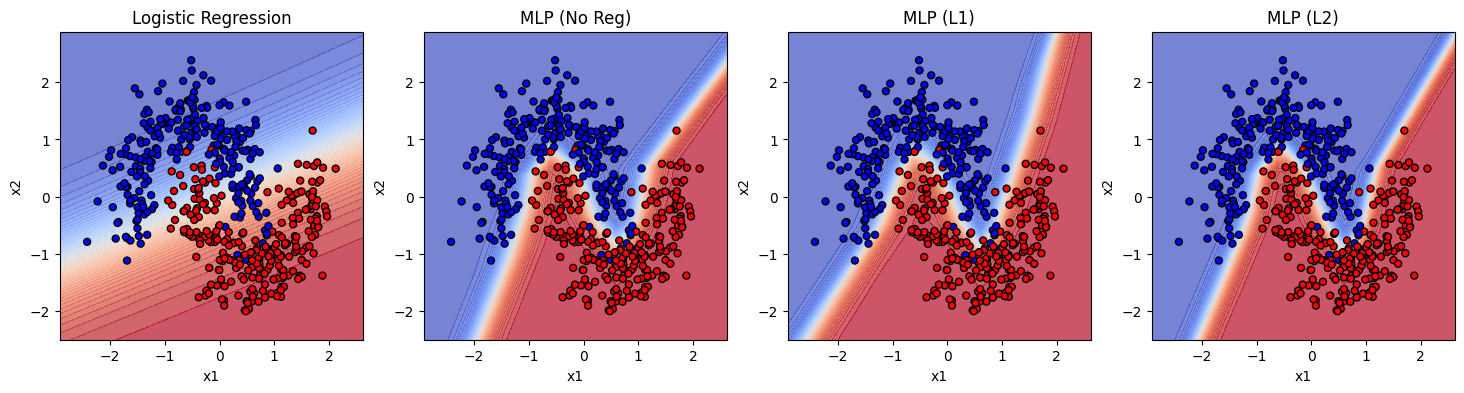

In [47]:
# Plot decision boundaries
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
titles = ["Logistic Regression", "MLP (No Reg)", "MLP (L1)", "MLP (L2)"]
Zs = [Z_logreg, Z_mlp_no, Z_mlp_l1, Z_mlp_l2]

for ax, Z, title in zip(axes, Zs, titles):
    ax.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.7)
    scatter = ax.scatter(X1, X2, c=y_test_02, cmap="bwr", edgecolor="k", s=25)
    ax.set_title(title, fontsize=12)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")


# Using an Imbalanced Train Set (70:30) but a Balanced Test Set

In [48]:
# Train set with imbalance
X_train_imbal, y_train_imbal = generate_make_moons(n_samples=400, noise=0.2, imbalance_ratio=0.7, random_state=SEED)

In [49]:
# Convert to tensors
X_train_tensor_imbal = torch.tensor(X_train_imbal, dtype=torch.float32)
y_train_tensor_imbal = torch.tensor(y_train_imbal, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor_imbal, y_train_tensor_imbal)

# Create DataLoaders
train_loader_imbal = DataLoader(train_dataset, batch_size=32, shuffle=True)

**MLP with No Regularization**

In [51]:
# Train with imbalanced train set
model_mlp_imbal, best_val_auc = train_mlp_no_reg(train_loader_imbal, val_loader)

Epoch 0 | Train Loss=8.6991 | Val AUROC=0.2764
Epoch 50 | Train Loss=3.8021 | Val AUROC=0.9284
Epoch 100 | Train Loss=3.2973 | Val AUROC=0.9304
Early stopping at epoch 108


In [52]:
# Validation AUROC
print(f"Val AUROC: {best_val_auc:.4f}")

Val AUROC: 0.9316


In [53]:
# Evaluate on test set
mlp_results_imbal = evaluate_mlp(model_mlp_imbal, test_sets)

for noise, res in mlp_results_imbal.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

noise_0.2 | Accuracy: 0.8540 | AUROC: 0.9499
noise_0.1 | Accuracy: 0.8560 | AUROC: 0.9550
noise_0.3 | Accuracy: 0.8260 | AUROC: 0.9156


**MLP with L1 regularization**

In [57]:
# Train with imbalanced train set
model_l1_imbal, best_auc_imbal = train_with_l1(1e-4, train_loader, val_loader)

Epoch 0 | Train Loss=10.1743 | Val AUROC=0.1896
Epoch 50 | Train Loss=4.0904 | Val AUROC=0.9332
Epoch 100 | Train Loss=3.6573 | Val AUROC=0.9428
Epoch 150 | Train Loss=3.0531 | Val AUROC=0.9612
Epoch 200 | Train Loss=2.5295 | Val AUROC=0.9760
Epoch 250 | Train Loss=2.1311 | Val AUROC=0.9820
Epoch 300 | Train Loss=1.6953 | Val AUROC=0.9872
Epoch 350 | Train Loss=1.4558 | Val AUROC=0.9924
Epoch 400 | Train Loss=1.3310 | Val AUROC=0.9936
Early stopping at epoch 443


In [58]:
# Validation sparsity (layer-wise) and AUROC
final_sparsity = compute_sparsity(model_l1_imbal)
print(f"Hidden Sparsity: {final_sparsity['hidden.weight']:.2f}% | Output Sparsity: {final_sparsity['out.weight']:.2f}% | Validation AUROC: {best_auc_imbal}")

Hidden Sparsity: 9.38% | Output Sparsity: 6.25% | Validation AUROC: 0.994


In [59]:
# Evaluate on test set
mlp_l1_results_imbal = evaluate_mlp(model_l1_imbal, test_sets)

for noise, res in mlp_l1_results_imbal.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

noise_0.2 | Accuracy: 0.9660 | AUROC: 0.9935
noise_0.1 | Accuracy: 0.9940 | AUROC: 0.9999
noise_0.3 | Accuracy: 0.9000 | AUROC: 0.9613


**MLP with L2 Regularization**

In [61]:
# Train with imbalanced train set
model_l2_imbal, best_auc_imbal = train_with_l2(1e-5, train_loader, val_loader)

Epoch 0 | Train Loss=9.3547 | Val AUROC=0.4516
Epoch 50 | Train Loss=3.9214 | Val AUROC=0.9332
Epoch 100 | Train Loss=3.4118 | Val AUROC=0.9484
Epoch 150 | Train Loss=2.8021 | Val AUROC=0.9672
Epoch 200 | Train Loss=2.1476 | Val AUROC=0.9780
Epoch 250 | Train Loss=1.7289 | Val AUROC=0.9868
Epoch 300 | Train Loss=1.5420 | Val AUROC=0.9916
Epoch 350 | Train Loss=1.3272 | Val AUROC=0.9940
Epoch 400 | Train Loss=1.1929 | Val AUROC=0.9948
Early stopping at epoch 417


In [62]:
# Validation AUROC
print(f"Validation AUROC: {best_auc_imbal:.4f}")

Validation AUROC: 0.9948


In [63]:
# Evaluate on test set
mlp_l2_results_imbal = evaluate_mlp(model_l2_imbal, test_sets)

for noise, res in mlp_l2_results_imbal.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

noise_0.2 | Accuracy: 0.9660 | AUROC: 0.9934
noise_0.1 | Accuracy: 0.9980 | AUROC: 1.0000
noise_0.3 | Accuracy: 0.8880 | AUROC: 0.9586


**Logistic Regression with Polynomial Features**

In [64]:
# Polynomial features of degree 2 for imbalanced train set
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_imbal = poly.fit_transform(X_train_imbal)

In [65]:
# Train logistic regression model
logreg_imbal = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg_imbal.fit(X_train_poly_imbal, y_train_imbal)

LogisticRegression(max_iter=5000)

In [66]:
# Predictions on validation set
y_val_pred = logreg_imbal.predict(X_val_poly)
y_val_prob = logreg_imbal.predict_proba(X_val_poly)[:, 1]

In [67]:
# Evaluations on validation set
acc = accuracy_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_prob)

print(f"Logistic Regression Validation Accuracy: {acc:.4f}")
print(f"Logistic Regression Validation AUROC: {auc:.4f}")

Logistic Regression Validation Accuracy: 0.8200
Logistic Regression Validation AUROC: 0.9248


In [68]:
# Evaluations on test set
logreg_imbal_results = evaluate_logreg(logreg_imbal, test_sets_poly)

for noise, res in logreg_imbal_results.items():
    print(f"{noise} | Accuracy: {res['accuracy']:.4f} | AUROC: {res['AUROC']:.4f}")

0.20 noise | Accuracy: 0.8580 | AUROC: 0.9423
0.10 noise | Accuracy: 0.8780 | AUROC: 0.9547
0.30 noise | Accuracy: 0.8240 | AUROC: 0.9081


**Decision Boundaries**

In [69]:
# Extract test set (0.2 noise)
X_test_02, y_test_02 = test_sets["noise_0.2"]
X1, X2 = X_test_02[:, 0], X_test_02[:, 1]

In [70]:
# Create grid for plotting
x_min, x_max = X1.min() - 0.5, X1.max() + 0.5
y_min, y_max = X2.min() - 0.5, X2.max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

In [71]:
# Function to compute model predictions over grid
def get_decision_boundary(model, model_type, xx, yy):
    grid = np.c_[xx.ravel(), yy.ravel()]

    if model_type == "logreg":
        grid_poly = poly.transform(grid)  
        probs = model.predict_proba(grid_poly)[:, 1]

    elif model_type.startswith("mlp"):
        model.eval()
        with torch.no_grad():
            grid_t = torch.tensor(grid, dtype=torch.float32)
            probs = torch.sigmoid(model(grid_t)).cpu().numpy().ravel()

    return probs.reshape(xx.shape)

In [72]:
# Compute probabilities for all models
Z_logreg = get_decision_boundary(logreg_imbal, "logreg", xx, yy)
Z_mlp_no = get_decision_boundary(model_mlp_imbal, "mlp_no_reg", xx, yy)
Z_mlp_l1 = get_decision_boundary(model_l1_imbal, "mlp_l1", xx, yy)
Z_mlp_l2 = get_decision_boundary(model_l2_imbal, "mlp_l2", xx, yy)

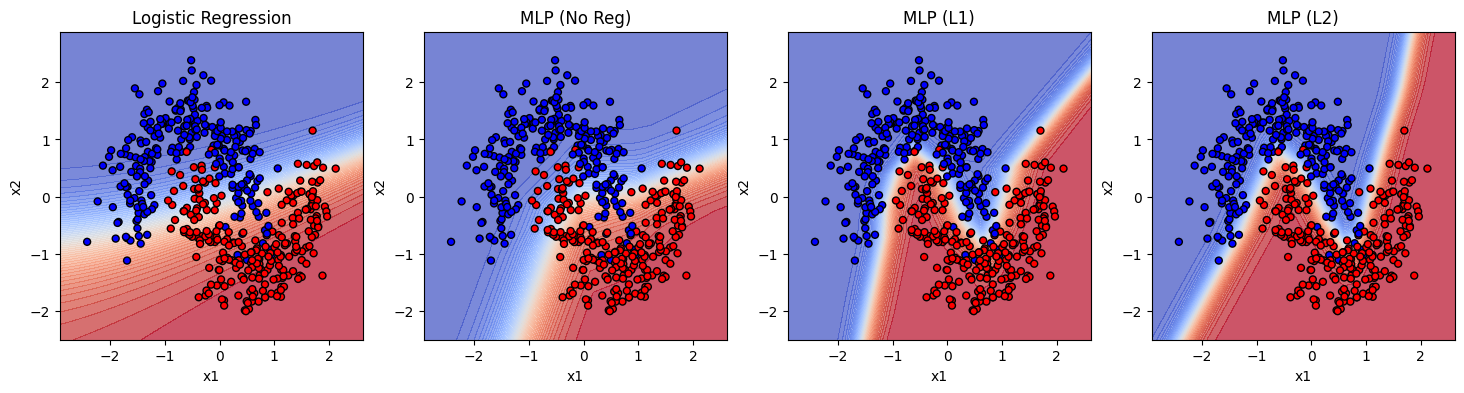

In [73]:
# Plot decision boundaries
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
titles = ["Logistic Regression", "MLP (No Reg)", "MLP (L1)", "MLP (L2)"]
Zs = [Z_logreg, Z_mlp_no, Z_mlp_l1, Z_mlp_l2]

for ax, Z, title in zip(axes, Zs, titles):
    ax.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.7)
    scatter = ax.scatter(X1, X2, c=y_test_02, cmap="bwr", edgecolor="k", s=25)
    ax.set_title(title, fontsize=12)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")